In [1]:
trial_number_ml = "007"
random_state_init = 777

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n


In [4]:
def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model1_files = ['../../data_for_ml/ml_datasets_set2/model1_rna_bin_non_rna_bin/data.pkl']

# Load datasets
model1_df = load_and_concatenate_datasets(model1_files)

# Preprocess datasets
X1, y1 = preprocess_data(model1_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X1, y1)

# Output shapes
print(f"Model 1 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 1 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 17:00:45,868] A new study created in memory with name: no-name-4d402dd2-068e-4327-bdc4-52bbf0515ed3


[I 2024-05-01 17:01:19,528] Trial 1 finished with value: 0.6171410721360436 and parameters: {'n_estimators': 221, 'max_depth': 23, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.6171410721360436.


[I 2024-05-01 17:01:44,628] Trial 3 finished with value: 0.6247920031694755 and parameters: {'n_estimators': 294, 'max_depth': 99, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 3 with value: 0.6247920031694755.


[I 2024-05-01 17:02:56,016] Trial 0 finished with value: 0.625430469630939 and parameters: {'n_estimators': 807, 'max_depth': 67, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.625430469630939.


[I 2024-05-01 17:03:23,350] Trial 4 finished with value: 0.6251119982933593 and parameters: {'n_estimators': 903, 'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.625430469630939.


[I 2024-05-01 17:03:37,945] Trial 5 finished with value: 0.6251109824358233 and parameters: {'n_estimators': 706, 'max_depth': 92, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.625430469630939.


[I 2024-05-01 17:03:48,697] Trial 2 finished with value: 0.6263919787888946 and parameters: {'n_estimators': 745, 'max_depth': 91, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6263919787888946.


[I 2024-05-01 17:03:49,390] Trial 6 finished with value: 0.6235216733205335 and parameters: {'n_estimators': 267, 'max_depth': 37, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6263919787888946.


[I 2024-05-01 17:03:50,649] Trial 7 pruned. 


[I 2024-05-01 17:04:33,918] Trial 10 pruned. 


[I 2024-05-01 17:04:47,626] Trial 12 pruned. 


[I 2024-05-01 17:05:18,119] Trial 13 pruned. 


[I 2024-05-01 17:05:31,047] Trial 8 finished with value: 0.631490059834009 and parameters: {'n_estimators': 566, 'max_depth': 76, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.631490059834009.


[I 2024-05-01 17:05:44,027] Trial 9 finished with value: 0.6247904793831713 and parameters: {'n_estimators': 706, 'max_depth': 78, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 8 with value: 0.631490059834009.


[I 2024-05-01 17:06:01,476] Trial 15 pruned. 


[I 2024-05-01 17:06:05,758] Trial 14 pruned. 


[I 2024-05-01 17:06:35,914] Trial 16 pruned. 


[I 2024-05-01 17:07:20,760] Trial 11 finished with value: 0.6283012830280682 and parameters: {'n_estimators': 975, 'max_depth': 71, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.631490059834009.


[I 2024-05-01 17:07:26,821] Trial 20 pruned. 


[I 2024-05-01 17:07:33,766] Trial 17 pruned. 


[I 2024-05-01 17:07:44,519] Trial 18 finished with value: 0.630213126911082 and parameters: {'n_estimators': 416, 'max_depth': 52, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.631490059834009.


[I 2024-05-01 17:08:04,638] Trial 23 pruned. 


[I 2024-05-01 17:08:16,706] Trial 22 pruned. 


[I 2024-05-01 17:08:38,648] Trial 19 finished with value: 0.6311685409238208 and parameters: {'n_estimators': 491, 'max_depth': 100, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.631490059834009.


[I 2024-05-01 17:09:04,697] Trial 26 pruned. 


[I 2024-05-01 17:09:34,161] Trial 27 pruned. 


[I 2024-05-01 17:09:54,116] Trial 24 finished with value: 0.6286182305793436 and parameters: {'n_estimators': 440, 'max_depth': 62, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.631490059834009.


[I 2024-05-01 17:09:59,187] Trial 28 pruned. 


[I 2024-05-01 17:10:12,431] Trial 29 pruned. 


[I 2024-05-01 17:10:17,044] Trial 30 pruned. 


[I 2024-05-01 17:10:35,003] Trial 31 pruned. 


[I 2024-05-01 17:10:36,382] Trial 25 finished with value: 0.6324464897042839 and parameters: {'n_estimators': 545, 'max_depth': 60, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 25 with value: 0.6324464897042839.


[I 2024-05-01 17:10:47,516] Trial 32 pruned. 


[I 2024-05-01 17:10:59,160] Trial 21 finished with value: 0.6279812879041844 and parameters: {'n_estimators': 855, 'max_depth': 41, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 25 with value: 0.6324464897042839.


[I 2024-05-01 17:11:21,889] Trial 36 pruned. 


[I 2024-05-01 17:11:29,394] Trial 37 pruned. 


[I 2024-05-01 17:11:33,664] Trial 35 pruned. 


[I 2024-05-01 17:11:52,344] Trial 38 pruned. 


[I 2024-05-01 17:11:54,258] Trial 39 pruned. 


[I 2024-05-01 17:12:06,992] Trial 41 pruned. 


[I 2024-05-01 17:12:12,983] Trial 40 pruned. 


[I 2024-05-01 17:12:26,381] Trial 43 pruned. 


[I 2024-05-01 17:12:40,367] Trial 33 finished with value: 0.6308526092300817 and parameters: {'n_estimators': 656, 'max_depth': 76, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 25 with value: 0.6324464897042839.


[I 2024-05-01 17:12:41,440] Trial 34 finished with value: 0.6302121110535458 and parameters: {'n_estimators': 661, 'max_depth': 46, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 25 with value: 0.6324464897042839.


[I 2024-05-01 17:12:48,731] Trial 42 pruned. 


[I 2024-05-01 17:13:17,758] Trial 47 pruned. 


[I 2024-05-01 17:13:46,322] Trial 48 pruned. 


[I 2024-05-01 17:14:10,058] Trial 44 finished with value: 0.6337218988409066 and parameters: {'n_estimators': 573, 'max_depth': 65, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 44 with value: 0.6337218988409066.


[I 2024-05-01 17:14:26,714] Trial 49 pruned. 


[I 2024-05-01 17:14:31,743] Trial 45 finished with value: 0.6302126189823138 and parameters: {'n_estimators': 719, 'max_depth': 64, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 44 with value: 0.6337218988409066.


[I 2024-05-01 17:14:32,585] Trial 46 finished with value: 0.6276612927803005 and parameters: {'n_estimators': 734, 'max_depth': 65, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 44 with value: 0.6337218988409066.


Best trial for RandomForestClassifier:
  Value: 0.6337218988409066
  Params: 
    n_estimators: 573
    max_depth: 65
    min_samples_split: 4
    min_samples_leaf: 8
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 573, 'max_depth': 65, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}


[I 2024-05-01 17:14:46,165] A new study created in memory with name: no-name-d9f117db-f2e2-4b98-905e-cd23e888afae


RandomForestClassifier accuracy: 0.6178



[I 2024-05-01 17:14:51,048] Trial 0 finished with value: 0.6091747173376406 and parameters: {'n_estimators': 110, 'max_depth': 5, 'learning_rate': 0.1619951681838935, 'min_child_weight': 4, 'subsample': 0.9884456807641278, 'colsample_bytree': 0.8509630241059218, 'gamma': 3.3995773282366044, 'reg_lambda': 0.011476397349252163, 'reg_alpha': 0.022867915534254254}. Best is trial 0 with value: 0.6091747173376406.


[I 2024-05-01 17:14:51,659] Trial 2 finished with value: 0.5980226333059052 and parameters: {'n_estimators': 120, 'max_depth': 7, 'learning_rate': 0.21143506950147886, 'min_child_weight': 5, 'subsample': 0.6915381460174866, 'colsample_bytree': 0.6429943279853676, 'gamma': 3.2035244425431153, 'reg_lambda': 0.25713451011448984, 'reg_alpha': 0.011804628432943255}. Best is trial 0 with value: 0.6091747173376406.


[I 2024-05-01 17:14:55,199] Trial 4 finished with value: 0.6028007192271356 and parameters: {'n_estimators': 118, 'max_depth': 5, 'learning_rate': 0.29776104305427903, 'min_child_weight': 6, 'subsample': 0.9906610186166441, 'colsample_bytree': 0.7769764985986455, 'gamma': 1.1346583018135243, 'reg_lambda': 1.4183456598807125, 'reg_alpha': 0.7448283061887906}. Best is trial 0 with value: 0.6091747173376406.


[I 2024-05-01 17:14:57,878] Trial 3 finished with value: 0.6209713629760562 and parameters: {'n_estimators': 364, 'max_depth': 8, 'learning_rate': 0.04691787737680386, 'min_child_weight': 2, 'subsample': 0.9184046137843096, 'colsample_bytree': 0.5646045198630048, 'gamma': 1.1295654191718107, 'reg_lambda': 0.028097613791883226, 'reg_alpha': 3.3478932189590185}. Best is trial 3 with value: 0.6209713629760562.


[I 2024-05-01 17:14:59,840] Trial 6 finished with value: 0.6063003484391348 and parameters: {'n_estimators': 113, 'max_depth': 5, 'learning_rate': 0.06583268077702019, 'min_child_weight': 9, 'subsample': 0.526787300092749, 'colsample_bytree': 0.5589483678224239, 'gamma': 0.20185386979850062, 'reg_lambda': 0.03664533978934995, 'reg_alpha': 0.03301011141354997}. Best is trial 3 with value: 0.6209713629760562.


[I 2024-05-01 17:15:01,556] Trial 7 pruned. 


[I 2024-05-01 17:15:02,375] Trial 8 pruned. 


[I 2024-05-01 17:15:02,607] Trial 5 finished with value: 0.6069469417608875 and parameters: {'n_estimators': 403, 'max_depth': 9, 'learning_rate': 0.23261016293837003, 'min_child_weight': 10, 'subsample': 0.7604025263405348, 'colsample_bytree': 0.7813906315984285, 'gamma': 1.1162617421804018, 'reg_lambda': 5.492174296340427, 'reg_alpha': 6.08377354903286}. Best is trial 3 with value: 0.6209713629760562.


[I 2024-05-01 17:15:03,383] Trial 9 pruned. 


[I 2024-05-01 17:15:03,797] Trial 10 pruned. 


[I 2024-05-01 17:15:04,489] Trial 1 finished with value: 0.6187395239691587 and parameters: {'n_estimators': 997, 'max_depth': 6, 'learning_rate': 0.0719735416280711, 'min_child_weight': 1, 'subsample': 0.9320215668626193, 'colsample_bytree': 0.8679492978268464, 'gamma': 4.491380736186887, 'reg_lambda': 0.01114355268523173, 'reg_alpha': 1.1116738327676037}. Best is trial 3 with value: 0.6209713629760562.


[I 2024-05-01 17:15:04,751] Trial 12 pruned. 


[I 2024-05-01 17:15:05,882] Trial 13 pruned. 


[I 2024-05-01 17:15:08,028] Trial 14 pruned. 


[I 2024-05-01 17:15:08,178] Trial 11 finished with value: 0.612682981338697 and parameters: {'n_estimators': 126, 'max_depth': 4, 'learning_rate': 0.03738525035667285, 'min_child_weight': 5, 'subsample': 0.8338401287670733, 'colsample_bytree': 0.7877672978965073, 'gamma': 0.13281481267826023, 'reg_lambda': 0.14104684814920962, 'reg_alpha': 0.112105793975229}. Best is trial 3 with value: 0.6209713629760562.


[I 2024-05-01 17:15:09,746] Trial 15 pruned. 


[I 2024-05-01 17:15:10,129] Trial 16 pruned. 


[I 2024-05-01 17:15:11,474] Trial 17 pruned. 


[I 2024-05-01 17:15:12,667] Trial 19 pruned. 


[I 2024-05-01 17:15:12,831] Trial 21 pruned. 


[I 2024-05-01 17:15:14,447] Trial 22 pruned. 


[I 2024-05-01 17:15:16,346] Trial 24 pruned. 


[I 2024-05-01 17:15:19,252] Trial 25 pruned. 


[I 2024-05-01 17:15:24,014] Trial 26 pruned. 


[I 2024-05-01 17:15:24,335] Trial 20 finished with value: 0.6247970824571561 and parameters: {'n_estimators': 623, 'max_depth': 6, 'learning_rate': 0.12249794391290378, 'min_child_weight': 3, 'subsample': 0.9133224384616931, 'colsample_bytree': 0.6918492840091728, 'gamma': 1.9614450244731019, 'reg_lambda': 0.047646203474024734, 'reg_alpha': 2.677959175557017}. Best is trial 20 with value: 0.6247970824571561.


[I 2024-05-01 17:15:24,607] Trial 23 finished with value: 0.6145948252217109 and parameters: {'n_estimators': 398, 'max_depth': 8, 'learning_rate': 0.05898385831441467, 'min_child_weight': 2, 'subsample': 0.6309004116734931, 'colsample_bytree': 0.7118925307500525, 'gamma': 3.8970060499741574, 'reg_lambda': 0.7093356040537473, 'reg_alpha': 0.9055231187931045}. Best is trial 20 with value: 0.6247970824571561.


[I 2024-05-01 17:15:25,999] Trial 18 finished with value: 0.6117229959670457 and parameters: {'n_estimators': 665, 'max_depth': 6, 'learning_rate': 0.11992730829669972, 'min_child_weight': 2, 'subsample': 0.8984632530767583, 'colsample_bytree': 0.7169878577338447, 'gamma': 1.7455371801714048, 'reg_lambda': 0.052258060861438235, 'reg_alpha': 1.9201922427113713}. Best is trial 20 with value: 0.6247970824571561.


[I 2024-05-01 17:15:26,318] Trial 28 pruned. 


[I 2024-05-01 17:15:27,393] Trial 27 pruned. 


[I 2024-05-01 17:15:29,108] Trial 31 pruned. 


[I 2024-05-01 17:15:29,347] Trial 30 pruned. 


[I 2024-05-01 17:15:31,155] Trial 34 pruned. 


[I 2024-05-01 17:15:31,463] Trial 32 pruned. 


[I 2024-05-01 17:15:31,989] Trial 33 pruned. 


[I 2024-05-01 17:15:34,000] Trial 35 pruned. 


[I 2024-05-01 17:15:34,123] Trial 36 pruned. 


[I 2024-05-01 17:15:34,400] Trial 37 pruned. 


[I 2024-05-01 17:15:35,740] Trial 38 pruned. 


[I 2024-05-01 17:15:35,983] Trial 39 pruned. 


[I 2024-05-01 17:15:36,618] Trial 40 pruned. 


[I 2024-05-01 17:15:37,131] Trial 41 pruned. 


[I 2024-05-01 17:15:37,961] Trial 29 finished with value: 0.6190600270218104 and parameters: {'n_estimators': 495, 'max_depth': 7, 'learning_rate': 0.11111576213359681, 'min_child_weight': 2, 'subsample': 0.9355221089967767, 'colsample_bytree': 0.5958234867120262, 'gamma': 2.235084523532027, 'reg_lambda': 0.025193093624028173, 'reg_alpha': 3.402864394148163}. Best is trial 20 with value: 0.6247970824571561.


[I 2024-05-01 17:15:39,237] Trial 43 pruned. 


[I 2024-05-01 17:15:41,479] Trial 46 pruned. 


[I 2024-05-01 17:15:42,362] Trial 44 finished with value: 0.6212898343136359 and parameters: {'n_estimators': 105, 'max_depth': 6, 'learning_rate': 0.049378520558889014, 'min_child_weight': 5, 'subsample': 0.9138805261229547, 'colsample_bytree': 0.7945723351474748, 'gamma': 0.3924398052121633, 'reg_lambda': 0.14090167033072135, 'reg_alpha': 0.6869787420585668}. Best is trial 20 with value: 0.6247970824571561.


[I 2024-05-01 17:15:43,364] Trial 47 pruned. 


[I 2024-05-01 17:15:45,795] Trial 42 finished with value: 0.6161902294822174 and parameters: {'n_estimators': 262, 'max_depth': 9, 'learning_rate': 0.17277551555730455, 'min_child_weight': 1, 'subsample': 0.7959597978343294, 'colsample_bytree': 0.8300156946832784, 'gamma': 0.6821374621525733, 'reg_lambda': 3.5707761896684653, 'reg_alpha': 6.901191258872932}. Best is trial 20 with value: 0.6247970824571561.


[I 2024-05-01 17:15:47,027] Trial 48 pruned. 


[I 2024-05-01 17:15:47,064] Trial 49 pruned. 


[I 2024-05-01 17:15:47,370] Trial 45 finished with value: 0.621925761131259 and parameters: {'n_estimators': 281, 'max_depth': 6, 'learning_rate': 0.08008525337059641, 'min_child_weight': 1, 'subsample': 0.9259007154703389, 'colsample_bytree': 0.6578868932464962, 'gamma': 0.7642942538827985, 'reg_lambda': 0.03665454074044387, 'reg_alpha': 0.7421558814916546}. Best is trial 20 with value: 0.6247970824571561.


Best trial for XGBClassifier:
  Value: 0.6247970824571561
  Params: 
    n_estimators: 623
    max_depth: 6
    learning_rate: 0.12249794391290378
    min_child_weight: 3
    subsample: 0.9133224384616931
    colsample_bytree: 0.6918492840091728
    gamma: 1.9614450244731019
    reg_lambda: 0.047646203474024734
    reg_alpha: 2.677959175557017

Best hyperparameters for XGBClassifier: {'n_estimators': 623, 'max_depth': 6, 'learning_rate': 0.12249794391290378, 'min_child_weight': 3, 'subsample': 0.9133224384616931, 'colsample_bytree': 0.6918492840091728, 'gamma': 1.9614450244731019, 'reg_lambda': 0.047646203474024734, 'reg_alpha': 2.677959175557017}


[I 2024-05-01 17:16:19,810] A new study created in memory with name: no-name-bb07f491-3e81-470a-a7dd-c7127f8a5ac8


XGBClassifier accuracy: 0.5975



[I 2024-05-01 17:16:20,533] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': 15, 'learning_rate': 0.3684520756779133, 'n_estimators': 372, 'min_child_weight': 0.014744028562458497, 'min_child_samples': 1515, 'subsample': 0.8033727725497346, 'colsample_bytree': 0.8472465502821932, 'reg_alpha': 1.641964126154039e-07, 'reg_lambda': 2.2905534492037503e-07}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 17:16:20,637] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 54, 'max_depth': 14, 'learning_rate': 0.4812318515133547, 'n_estimators': 490, 'min_child_weight': 0.006712890228629027, 'min_child_samples': 1276, 'subsample': 0.9998702376186077, 'colsample_bytree': 0.9414115250054635, 'reg_alpha': 0.0005590820319114725, 'reg_lambda': 0.19547041817124397}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 17:16:21,118] Trial 4 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 65, 'max_depth': 6, 'learning_rate': 0.06804344359383578, 'n_estimators': 405, 'min_child_weight': 0.009206809189854727, 'min_child_samples': 1790, 'subsample': 0.8932572403593478, 'colsample_bytree': 0.9658609399279958, 'reg_alpha': 0.0028788524035676883, 'reg_lambda': 1.7544329516578496e-05}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 17:16:22,234] Trial 3 finished with value: 0.5913342272879651 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'max_depth': 8, 'learning_rate': 0.06273794346868092, 'n_estimators': 253, 'min_child_weight': 0.026560348453709484, 'min_child_samples': 505, 'subsample': 0.8855230125553804, 'colsample_bytree': 0.9636489152811522, 'reg_alpha': 1.1136443022051464e-05, 'reg_lambda': 2.215457468600838e-10}. Best is trial 3 with value: 0.5913342272879651.


[I 2024-05-01 17:16:23,983] Trial 2 finished with value: 0.5967528113857312 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 7, 'learning_rate': 0.07175844600543455, 'n_estimators': 600, 'min_child_weight': 0.007649555166828293, 'min_child_samples': 591, 'subsample': 0.9760266442617922, 'colsample_bytree': 0.9164677122485827, 'reg_alpha': 6.44569848641405e-07, 'reg_lambda': 2.0390216451223086e-09}. Best is trial 2 with value: 0.5967528113857312.


[I 2024-05-01 17:16:24,412] Trial 6 finished with value: 0.5948333485711963 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'max_depth': 4, 'learning_rate': 0.11475276252283641, 'n_estimators': 384, 'min_child_weight': 0.002223280549103179, 'min_child_samples': 487, 'subsample': 0.8677788835066216, 'colsample_bytree': 0.8459468332534337, 'reg_alpha': 1.2352851839851873e-09, 'reg_lambda': 3.7443330468971584e-09}. Best is trial 2 with value: 0.5967528113857312.


[I 2024-05-01 17:16:24,553] Trial 8 pruned. 


[I 2024-05-01 17:16:24,663] Trial 10 pruned. 


[I 2024-05-01 17:16:26,374] Trial 9 finished with value: 0.5428646166661587 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'max_depth': 10, 'learning_rate': 0.48855016029693454, 'n_estimators': 517, 'min_child_weight': 0.06433754290981995, 'min_child_samples': 1150, 'subsample': 0.9412111711863805, 'colsample_bytree': 0.9601452593809919, 'reg_alpha': 0.24956662192713602, 'reg_lambda': 2.2997259390030435e-07}. Best is trial 2 with value: 0.5967528113857312.


[I 2024-05-01 17:16:28,242] Trial 11 finished with value: 0.5712532634423348 and parameters: {'boosting_type': 'goss', 'num_leaves': 97, 'max_depth': -1, 'learning_rate': 0.08720654224059977, 'n_estimators': 845, 'min_child_weight': 0.0021146646104589126, 'min_child_samples': 859, 'subsample': 0.9138797055725615, 'colsample_bytree': 0.9266049035819287, 'reg_alpha': 1.8383802179064846e-09, 'reg_lambda': 0.0005490722785782845}. Best is trial 2 with value: 0.5967528113857312.


[I 2024-05-01 17:16:29,568] Trial 12 finished with value: 0.5868659779152572 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'max_depth': 0, 'learning_rate': 0.32439145315868045, 'n_estimators': 656, 'min_child_weight': 0.003674598929415925, 'min_child_samples': 818, 'subsample': 0.9723909123726513, 'colsample_bytree': 0.9527917760462041, 'reg_alpha': 4.569959547288562e-06, 'reg_lambda': 1.2141794106549526e-05}. Best is trial 2 with value: 0.5967528113857312.


[I 2024-05-01 17:16:31,482] Trial 7 finished with value: 0.5961107894228913 and parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'max_depth': 0, 'learning_rate': 0.42358491877868226, 'n_estimators': 391, 'min_child_weight': 0.08969988795885375, 'min_child_samples': 654, 'subsample': 0.9609713832550639, 'colsample_bytree': 0.8261756472356024, 'reg_alpha': 0.17431227954340822, 'reg_lambda': 0.04965095665405437}. Best is trial 2 with value: 0.5967528113857312.


[I 2024-05-01 17:16:32,438] Trial 14 finished with value: 0.6059920356769167 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'max_depth': 3, 'learning_rate': 0.15755041620779947, 'n_estimators': 146, 'min_child_weight': 0.0010194410553477104, 'min_child_samples': 88, 'subsample': 0.8477782879552149, 'colsample_bytree': 0.8632997830495484, 'reg_alpha': 4.1676788033925e-10, 'reg_lambda': 1.6217577546851003e-08}. Best is trial 14 with value: 0.6059920356769167.


[I 2024-05-01 17:16:33,090] Trial 16 pruned. 


[I 2024-05-01 17:16:34,813] Trial 5 pruned. 


[I 2024-05-01 17:16:36,794] Trial 15 finished with value: 0.5916521906967767 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 11, 'learning_rate': 0.004992961838059681, 'n_estimators': 117, 'min_child_weight': 0.0841616395139427, 'min_child_samples': 94, 'subsample': 0.9398406758747733, 'colsample_bytree': 0.8006507439657012, 'reg_alpha': 4.048761975440984e-07, 'reg_lambda': 0.6491563879190522}. Best is trial 14 with value: 0.6059920356769167.


[I 2024-05-01 17:17:10,495] Trial 19 finished with value: 0.6012012515364845 and parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'max_depth': 8, 'learning_rate': 0.16619472552410305, 'n_estimators': 800, 'min_child_weight': 0.029574777497929007, 'min_child_samples': 289, 'subsample': 0.8442824332175135, 'colsample_bytree': 0.9994509315290028, 'reg_alpha': 1.1065879754072287e-10, 'reg_lambda': 3.881643538651487e-09}. Best is trial 14 with value: 0.6059920356769167.


[I 2024-05-01 17:17:21,951] Trial 13 finished with value: 0.6040796838651348 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 11, 'learning_rate': 0.0028415273345985537, 'n_estimators': 757, 'min_child_weight': 0.0047124891391351585, 'min_child_samples': 95, 'subsample': 0.828865055681737, 'colsample_bytree': 0.8027006070358178, 'reg_alpha': 4.260045422422014e-08, 'reg_lambda': 3.525789062786309e-08}. Best is trial 14 with value: 0.6059920356769167.


[I 2024-05-01 17:17:24,092] Trial 17 finished with value: 0.6021663161958167 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 9, 'learning_rate': 0.2142785705664277, 'n_estimators': 743, 'min_child_weight': 0.005008802273142818, 'min_child_samples': 60, 'subsample': 0.8432000587650653, 'colsample_bytree': 0.886217410866413, 'reg_alpha': 1.0195326399657073e-10, 'reg_lambda': 3.6900646404628654e-09}. Best is trial 14 with value: 0.6059920356769167.


[I 2024-05-01 17:17:35,696] Trial 18 finished with value: 0.5957872387976311 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 9, 'learning_rate': 0.16270741864404595, 'n_estimators': 790, 'min_child_weight': 0.030456968732086597, 'min_child_samples': 33, 'subsample': 0.8479038233810487, 'colsample_bytree': 0.8880107789813886, 'reg_alpha': 1.4892745037354606e-10, 'reg_lambda': 3.487742344740154e-09}. Best is trial 14 with value: 0.6059920356769167.


[I 2024-05-01 17:17:55,368] Trial 20 finished with value: 0.5967299545911681 and parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'max_depth': 9, 'learning_rate': 0.2502249081175558, 'n_estimators': 989, 'min_child_weight': 0.03483504050270649, 'min_child_samples': 291, 'subsample': 0.8358912038137388, 'colsample_bytree': 0.9972676701053683, 'reg_alpha': 1.6370698064475398e-10, 'reg_lambda': 4.777443819424454e-09}. Best is trial 14 with value: 0.6059920356769167.


[I 2024-05-01 17:18:03,051] Trial 21 finished with value: 0.6008802405550646 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 12, 'learning_rate': 0.26044733074106935, 'n_estimators': 959, 'min_child_weight': 0.001010406573946522, 'min_child_samples': 301, 'subsample': 0.8129103488584408, 'colsample_bytree': 0.8778471447934216, 'reg_alpha': 1.1475748681101064e-08, 'reg_lambda': 2.1981430032080474e-06}. Best is trial 14 with value: 0.6059920356769167.


[I 2024-05-01 17:18:04,948] Trial 22 finished with value: 0.6059793374577149 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 13, 'learning_rate': 0.30140229498715737, 'n_estimators': 939, 'min_child_weight': 0.0010654317380069027, 'min_child_samples': 309, 'subsample': 0.8008837576591255, 'colsample_bytree': 0.8621922194672009, 'reg_alpha': 1.0690443138927286e-08, 'reg_lambda': 1.080415536264992e-06}. Best is trial 14 with value: 0.6059920356769167.


[I 2024-05-01 17:18:16,251] Trial 23 finished with value: 0.6082106685358445 and parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'max_depth': 12, 'learning_rate': 0.3327671701245484, 'n_estimators': 955, 'min_child_weight': 0.0011015716291422045, 'min_child_samples': 348, 'subsample': 0.8227794623029179, 'colsample_bytree': 0.8578332527062937, 'reg_alpha': 1.2218062784184051e-08, 'reg_lambda': 3.0751854097122244e-06}. Best is trial 23 with value: 0.6082106685358445.


[I 2024-05-01 17:18:21,624] Trial 24 finished with value: 0.6053378234236432 and parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'max_depth': 13, 'learning_rate': 0.31844716155477776, 'n_estimators': 721, 'min_child_weight': 0.004209579141490655, 'min_child_samples': 377, 'subsample': 0.8072503828923226, 'colsample_bytree': 0.8685139844523815, 'reg_alpha': 8.303481310297118e-09, 'reg_lambda': 1.3081867731534873e-06}. Best is trial 23 with value: 0.6082106685358445.


[I 2024-05-01 17:18:27,299] Trial 28 pruned. 


[I 2024-05-01 17:18:34,938] Trial 25 finished with value: 0.5916420321214153 and parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'max_depth': 12, 'learning_rate': 0.304833763156369, 'n_estimators': 712, 'min_child_weight': 0.004363427964610874, 'min_child_samples': 238, 'subsample': 0.8164685615410472, 'colsample_bytree': 0.8648838785466536, 'reg_alpha': 3.3990292465022376e-09, 'reg_lambda': 3.386728162641782e-08}. Best is trial 23 with value: 0.6082106685358445.


[I 2024-05-01 17:18:35,770] Trial 30 pruned. 


[I 2024-05-01 17:18:43,287] Trial 26 finished with value: 0.6037464825932811 and parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'max_depth': 13, 'learning_rate': 0.3056879681007903, 'n_estimators': 919, 'min_child_weight': 0.0034889105159026795, 'min_child_samples': 341, 'subsample': 0.8202915286568228, 'colsample_bytree': 0.8477925484990052, 'reg_alpha': 4.8611076447695766e-09, 'reg_lambda': 0.0001667072112386954}. Best is trial 23 with value: 0.6082106685358445.


[I 2024-05-01 17:18:43,591] Trial 32 pruned. 


[I 2024-05-01 17:18:51,521] Trial 27 finished with value: 0.6018341307814993 and parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'max_depth': 13, 'learning_rate': 0.3233948246749516, 'n_estimators': 927, 'min_child_weight': 0.0013009253069202805, 'min_child_samples': 374, 'subsample': 0.8177639081579217, 'colsample_bytree': 0.8630675050142306, 'reg_alpha': 2.766138402211362e-09, 'reg_lambda': 0.0001262809952630312}. Best is trial 23 with value: 0.6082106685358445.


[I 2024-05-01 17:19:02,388] Trial 29 finished with value: 0.5996053393472099 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'max_depth': 13, 'learning_rate': 0.3832326905732048, 'n_estimators': 919, 'min_child_weight': 0.002969217131813841, 'min_child_samples': 415, 'subsample': 0.8185953566274025, 'colsample_bytree': 0.9013410013428339, 'reg_alpha': 5.59814017416446e-09, 'reg_lambda': 7.872259571623846e-05}. Best is trial 23 with value: 0.6082106685358445.


[I 2024-05-01 17:19:07,143] Trial 31 finished with value: 0.599292455226079 and parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'max_depth': 13, 'learning_rate': 0.3636052669817831, 'n_estimators': 877, 'min_child_weight': 0.0028466574355572355, 'min_child_samples': 482, 'subsample': 0.8232101594000779, 'colsample_bytree': 0.8423321210123217, 'reg_alpha': 1.0615541365184105e-08, 'reg_lambda': 2.6775829061022526e-06}. Best is trial 23 with value: 0.6082106685358445.


[I 2024-05-01 17:19:18,951] Trial 35 finished with value: 0.5957846991537907 and parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'max_depth': 15, 'learning_rate': 0.35176163257989757, 'n_estimators': 443, 'min_child_weight': 0.0016531154804601386, 'min_child_samples': 206, 'subsample': 0.8004006192432348, 'colsample_bytree': 0.8750397224232218, 'reg_alpha': 1.076168477518473e-06, 'reg_lambda': 9.901170416731658e-07}. Best is trial 23 with value: 0.6082106685358445.


[I 2024-05-01 17:19:19,250] Trial 33 finished with value: 0.6002534564552666 and parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'max_depth': 14, 'learning_rate': 0.3608050913524978, 'n_estimators': 995, 'min_child_weight': 0.00100052841181126, 'min_child_samples': 518, 'subsample': 0.8267933056426418, 'colsample_bytree': 0.8995093365786745, 'reg_alpha': 1.4002966438206692e-06, 'reg_lambda': 0.0013797555312420149}. Best is trial 23 with value: 0.6082106685358445.


[I 2024-05-01 17:19:20,159] Trial 37 pruned. 


[I 2024-05-01 17:19:21,893] Trial 39 pruned. 


[I 2024-05-01 17:19:22,110] Trial 40 pruned. 


[I 2024-05-01 17:19:24,832] Trial 41 pruned. 


[I 2024-05-01 17:19:25,291] Trial 38 pruned. 


[I 2024-05-01 17:19:25,518] Trial 43 pruned. 


[I 2024-05-01 17:19:28,432] Trial 42 pruned. 


[I 2024-05-01 17:19:34,468] Trial 34 finished with value: 0.5989724601021953 and parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'max_depth': 14, 'learning_rate': 0.36536699775108006, 'n_estimators': 871, 'min_child_weight': 0.002719098412626198, 'min_child_samples': 206, 'subsample': 0.8020080241636097, 'colsample_bytree': 0.8721615578197217, 'reg_alpha': 1.3061195725311957e-08, 'reg_lambda': 1.888002022481565e-06}. Best is trial 23 with value: 0.6082106685358445.


[I 2024-05-01 17:19:48,763] Trial 36 finished with value: 0.5887661394366054 and parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'max_depth': 15, 'learning_rate': 0.26700474808552127, 'n_estimators': 837, 'min_child_weight': 0.0010128656630303205, 'min_child_samples': 194, 'subsample': 0.8021719427278323, 'colsample_bytree': 0.8726790369718169, 'reg_alpha': 1.3936694773265372e-06, 'reg_lambda': 4.864852506973923e-07}. Best is trial 23 with value: 0.6082106685358445.


[I 2024-05-01 17:19:54,611] Trial 47 pruned. 


[I 2024-05-01 17:19:57,544] Trial 48 pruned. 


[I 2024-05-01 17:19:58,458] Trial 49 pruned. 


[I 2024-05-01 17:20:07,907] Trial 44 finished with value: 0.5992960107274556 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'max_depth': 12, 'learning_rate': 0.03734489057174209, 'n_estimators': 773, 'min_child_weight': 0.010011148262775908, 'min_child_samples': 159, 'subsample': 0.8311629050878868, 'colsample_bytree': 0.8110615696779261, 'reg_alpha': 4.803163447190299e-08, 'reg_lambda': 8.441468775443838e-07}. Best is trial 23 with value: 0.6082106685358445.


[I 2024-05-01 17:20:15,195] Trial 45 finished with value: 0.600248377167586 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'max_depth': 12, 'learning_rate': 0.03550711228131487, 'n_estimators': 761, 'min_child_weight': 0.009462598821427446, 'min_child_samples': 132, 'subsample': 0.8309525719005343, 'colsample_bytree': 0.8047103296218202, 'reg_alpha': 4.502653100934091e-08, 'reg_lambda': 1.8896193080306712e-08}. Best is trial 23 with value: 0.6082106685358445.


[I 2024-05-01 17:21:01,361] Trial 46 finished with value: 0.6136434746391167 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'max_depth': 12, 'learning_rate': 0.044653689761702205, 'n_estimators': 763, 'min_child_weight': 0.010298223681265064, 'min_child_samples': 24, 'subsample': 0.8291234078584652, 'colsample_bytree': 0.8094194417829658, 'reg_alpha': 4.545663847423045e-08, 'reg_lambda': 1.6482663837024265e-08}. Best is trial 46 with value: 0.6136434746391167.


Best trial for LGBMClassifier:
  Value: 0.6136434746391167
  Params: 
    boosting_type: dart
    num_leaves: 36
    max_depth: 12
    learning_rate: 0.044653689761702205
    n_estimators: 763
    min_child_weight: 0.010298223681265064
    min_child_samples: 24
    subsample: 0.8291234078584652
    colsample_bytree: 0.8094194417829658
    reg_alpha: 4.545663847423045e-08
    reg_lambda: 1.6482663837024265e-08

Best hyperparameters for LGBMClassifier: {'boosting_type': 'dart', 'num_leaves': 36, 'max_depth': 12, 'learning_rate': 0.044653689761702205, 'n_estimators': 763, 'min_child_weight': 0.010298223681265064, 'min_child_samples': 24, 'subsample': 0.8291234078584652, 'colsample_bytree': 0.8094194417829658, 'reg_alpha': 4.545663847423045e-08, 'reg_lambda': 1.6482663837024265e-08}


LGBMClassifier accuracy: 0.6089
LGBMClassifier accuracy: 0.6089



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_007/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

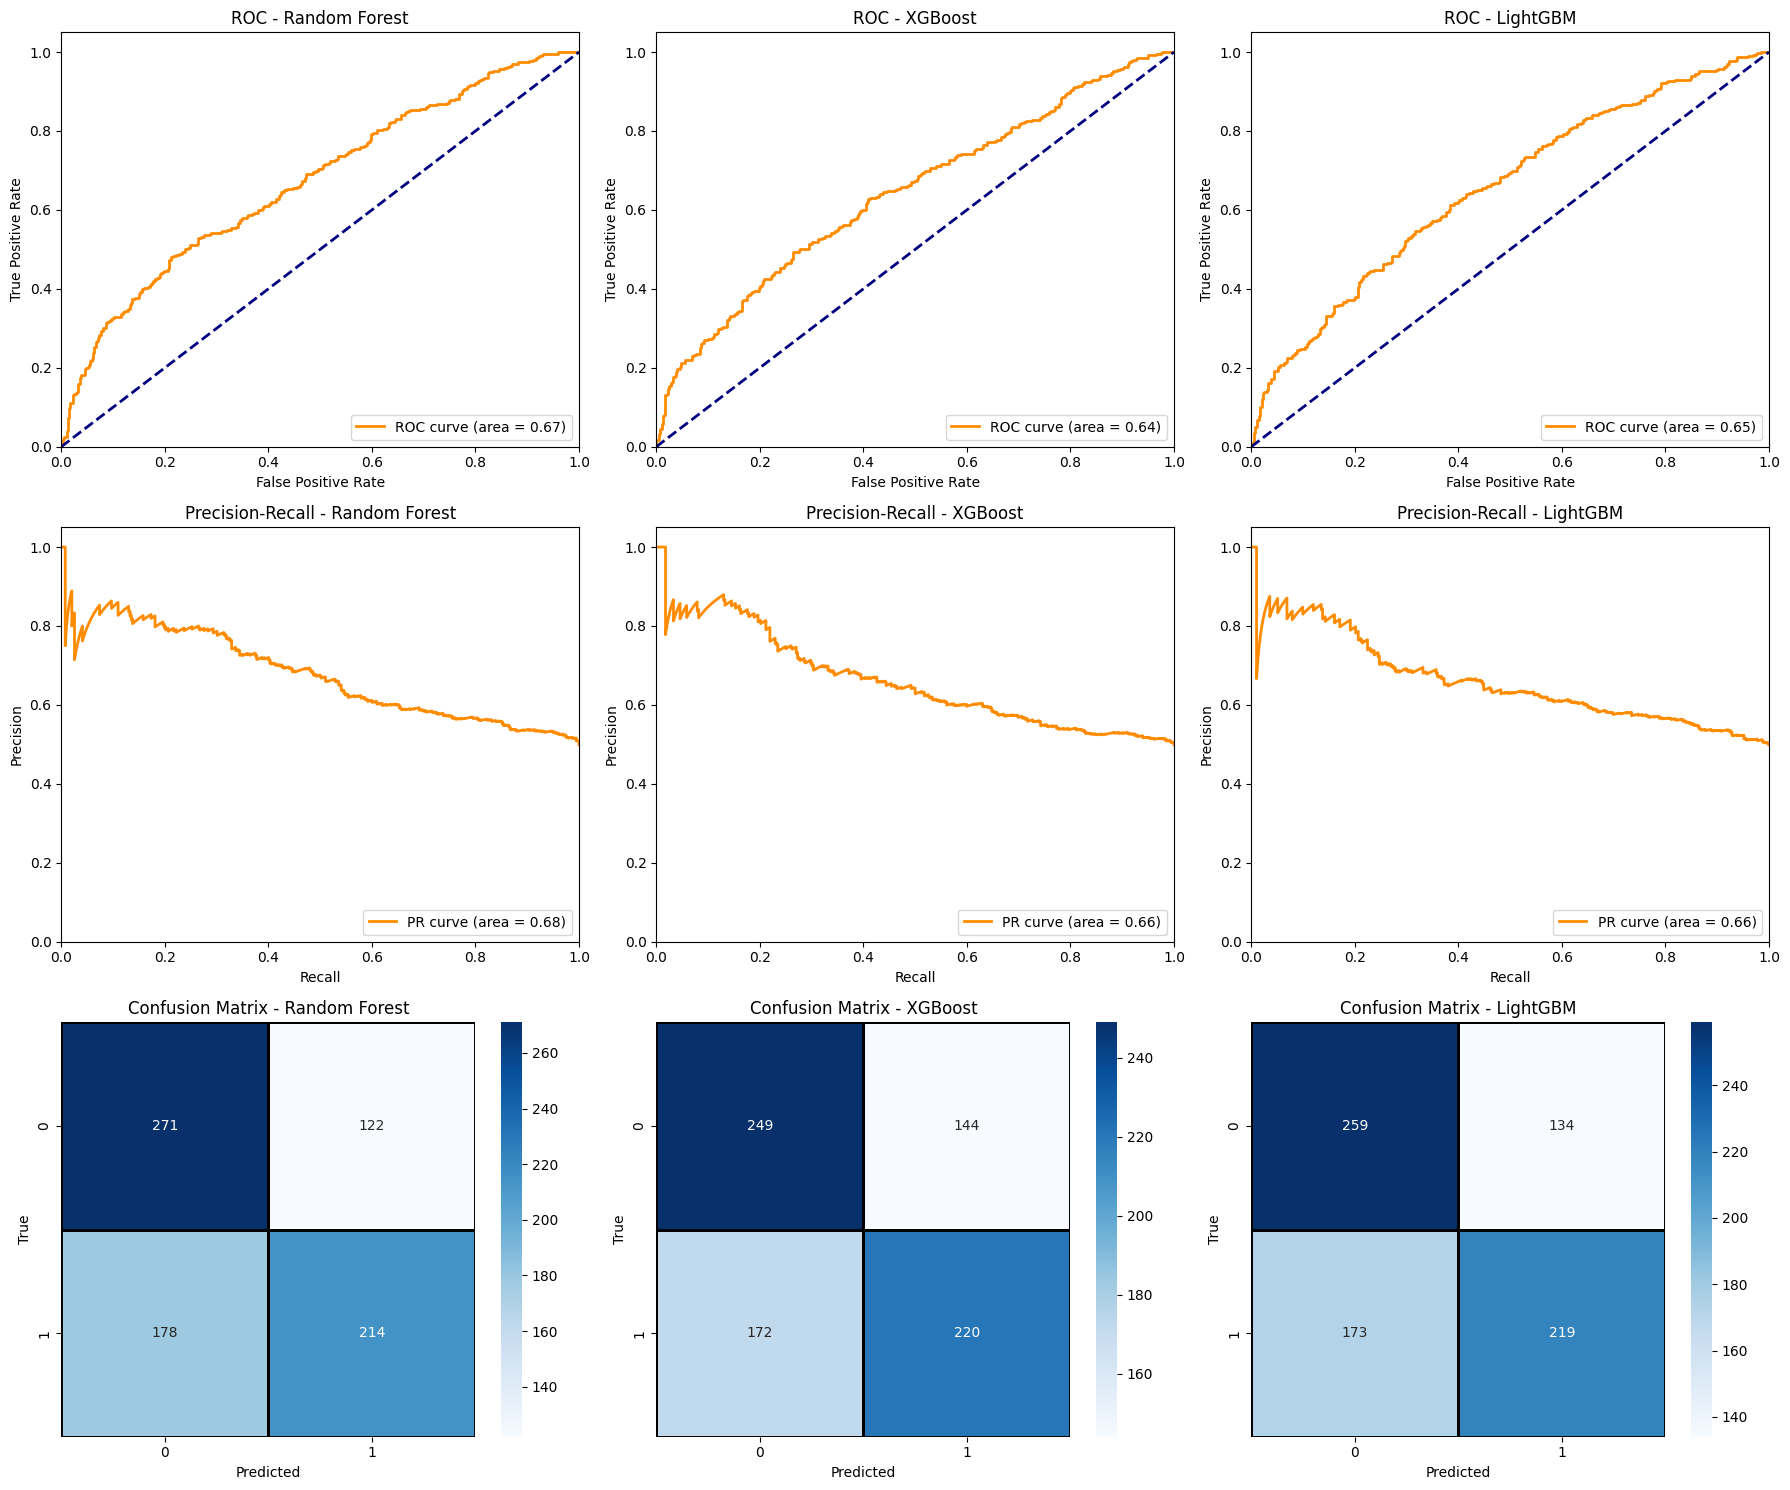

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.6178343949044586, 'Precision': 0.6369047619047619, 'Recall': 0.5459183673469388, 'F1 Score': 0.5879120879120879, 'ROC AUC': 0.6712169600664694}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.597452229299363, 'Precision': 0.6043956043956044, 'Recall': 0.5612244897959183, 'F1 Score': 0.582010582010582, 'ROC AUC': 0.6428571428571429}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.6089171974522293, 'Precision': 0.6203966005665722, 'Recall': 0.5586734693877551, 'F1 Score': 0.5879194630872483, 'ROC AUC': 0.6546840110089837}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.6089171974522293,
 'Precision': 0.6203966005665722,
 'Recall': 0.5586734693877551,
 'F1 Score': 0.5879194630872483,
 'ROC AUC': 0.6546840110089837}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.6178


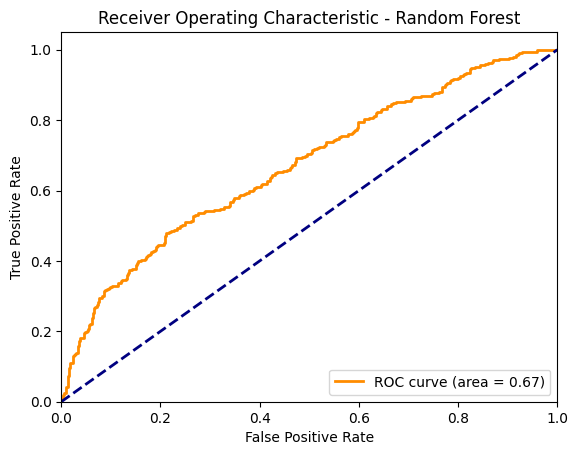

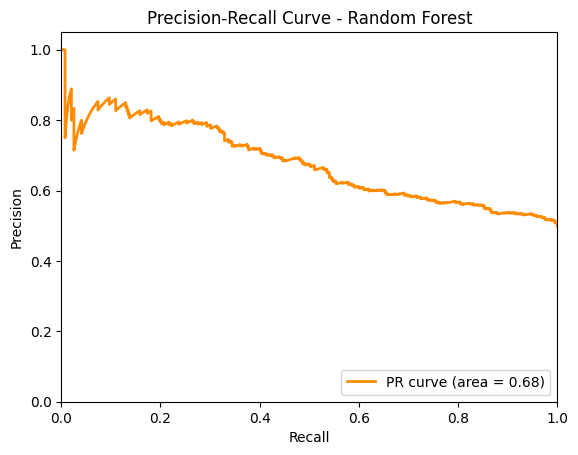

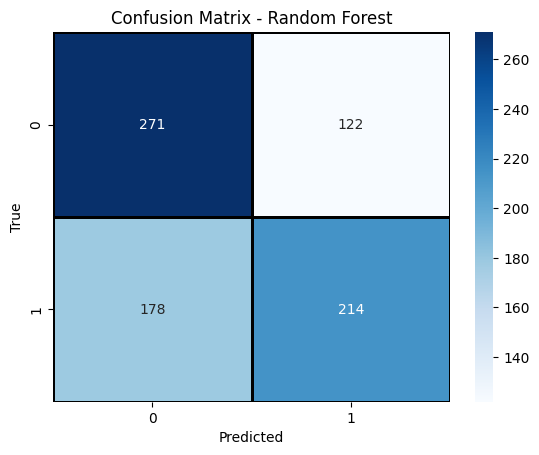

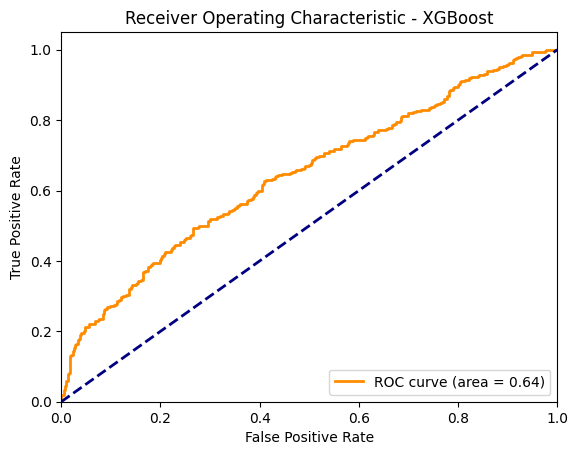

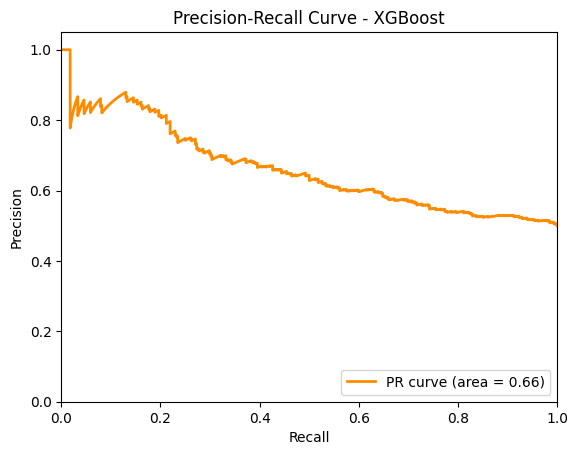

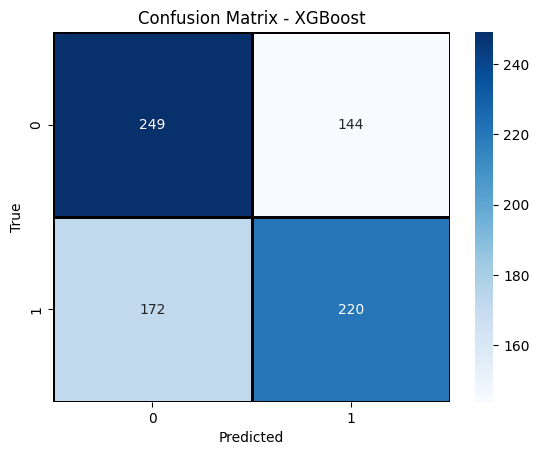

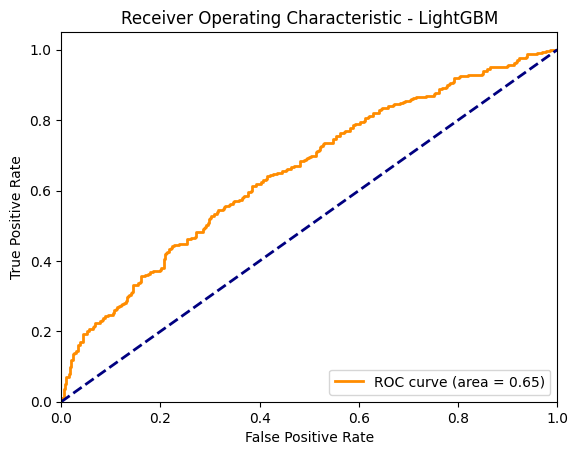

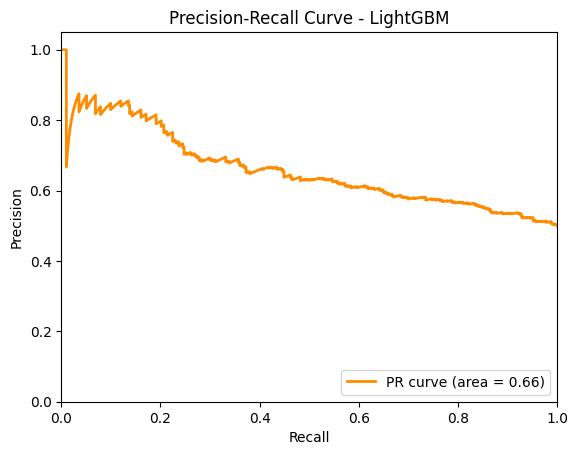

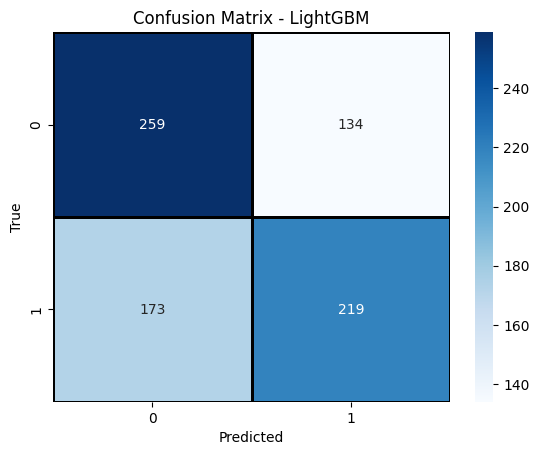

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

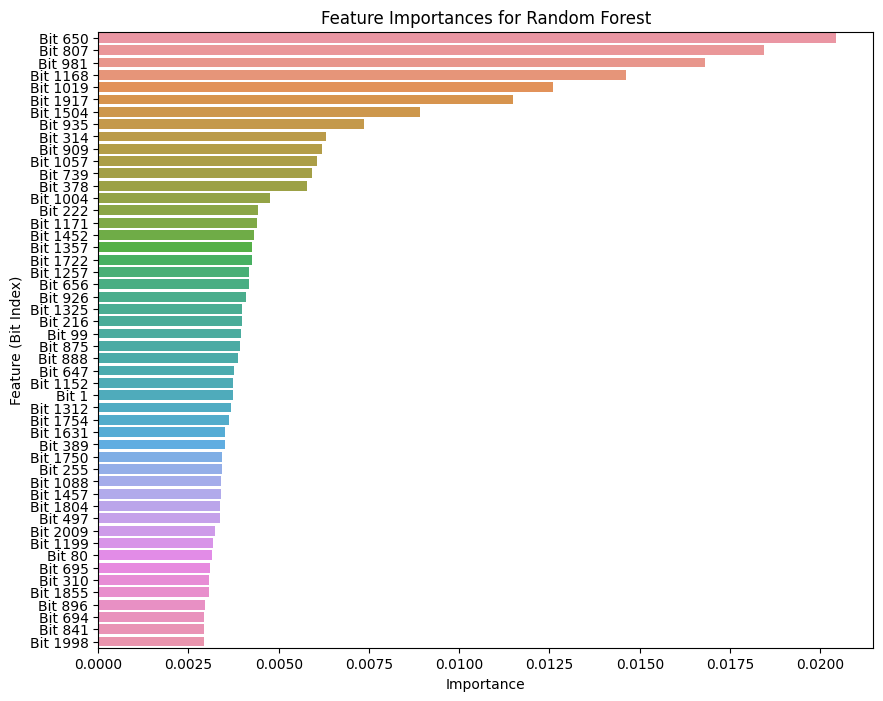

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
